# Lab 0: Introduction

This lab aims to exercise the basics of conducting experiments and training neural networks using it, while exploring how PyTorch works from the perspective of the user.

This notebook has the following overall structure:

- Building blocks for neural networks and data in PyTorch
  + [Task 0](#Task-0)
  + [Task 1](#Task-1)
  + [Task 2](#Task-2:-A-fully-connected-linear-layer)
  + [Task 3](#Task-3:-Loading-MNIST-data-and-batching)
- Building and evaluating an image classifier with a convolutional neural network
  + [Task 4](#Task-4:-A-simple-CNN)
  + [Task 5](#Task-5:-BatchNorm-and-Dropout)
  + [Task 6](#Task-6:-An-image-classifier-for-MNIST)
  + [Task 7](#Task-7:-Calculate-the-accuracy-of-your-model)
  + [Task 8](#Task-8:-Comparing-model-performance)
- Exploring the model performance with out-of-distribution data
  + [Task 9](#Task-9:-Rotating-MNIST)

<div style="font-weight:bold;">You need to complete all the tasks and show your solutions to one of the TA's to pass the lab. Please ask a TA to look at your solutions at suitably regular intervals during the lab. You should not wait until the very end to report your solutions, but we also recommend that you solve a mini-batch of tasks before showing your solutions.</div>

We start with some basic imports.

In [ ]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

There are two fundamental objects in PyTorch: `torch.Tensor` and `torch.nn.Module`.

**Note on devices (CPU/GPU):** Normally, those can be put into or moved from different `torch.device`s, but for this lab we will not use devices explicitly, which fallbacks to CPU-only computations. For more details on this, please consult the notebook on the basics of PyTorch.

# Tensors

Tensors represents muli-dimensional arrays of numbers used in any operation within PyTorch:
- rank-0 tensor is a scalar
- rank-1 tensor is a vector
- rank-2 tensor is a matrix
- rank-3 tensor is a volume
- ...and so on

We will most often use the `torch.tensor` function to initialize `torch.Tensor` objects.

In [ ]:
scalar = torch.tensor(0.1)
print('scalar: {:.4f}'.format(scalar))
print('scalar shape:', scalar.shape)

In [ ]:
vector = torch.tensor([0.1, 0.2, 0.3])
print('vector:', vector)
print('vector shape:', vector.shape)

In [ ]:
# Notice how `torch.tensor` already becomes inconvenient here.
# We use `torch.arange`, followed by reshape to create the tensor of a shape we want.

matrix = torch.arange(9).reshape([3, 3])
print('matrix:', matrix)
print('matrix shape:', matrix.shape)

In [ ]:
# We can also initialize things with the shape we want if we need a fixed value.
# Notice how we can also use a tuple (3, 3) instead of a list [3, 3] to indicate shapes.
matrix = torch.full((3, 3), 0.0)
# Setting the last column to ones
matrix[:, -1] = 1.0
print('matrix:', matrix)
print('matrix shape:', matrix.shape)

**NOTE:** As aliases, we also have `torch.zeros(shape)` and `torch.ones(shape)`, which do the same as `torch.full(shape, 0.0)` and `torch.full(shape, 1.0)`, respectively.

Within deep learning, it is usual to operate on tensors of rank above 2, especially when working with images, as three of those ranks are already used to represent a single image: one rank for the color channel (R, G, or B) and two ranks for the columns and rows of pixels within a channel.

## Task 0

What does a higher-order tensor look like when initializing with `torch.tensor`, `torch.arange`, or one of the initializers with value? Initialize the `image` variable with a tensor of shape (3, 8, 8) filled with zeroes.

In [ ]:
# Before implementing a solution:
# How is it supposed to be shown by `print` when the largest
# rank we can "see" in text is two?
# 2x2X2 
image = torch.zeros(2, 2 ,2)
print(image)

## Task 1
Produce the following $13\times 13$ matrix without using Python `for` loops:
$$
\begin{pmatrix}
1&2&1&1&1&1&2&1&1&1&1&2&1\\
2&2&2&2&2&2&2&2&2&2&2&2&2\\
1&2&1&1&1&1&2&1&1&1&1&2&1\\
1&2&1&3&3&1&2&1&3&3&1&2&1\\
1&2&1&3&3&1&2&1&3&3&1&2&1\\
1&2&1&1&1&1&2&1&1&1&1&2&1\\
2&2&2&2&2&2&2&2&2&2&2&2&2\\
1&2&1&1&1&1&2&1&1&1&1&2&1\\
1&2&1&3&3&1&2&1&3&3&1&2&1\\
1&2&1&3&3&1&2&1&3&3&1&2&1\\
1&2&1&1&1&1&2&1&1&1&1&2&1\\
2&2&2&2&2&2&2&2&2&2&2&2&2\\
1&2&1&1&1&1&2&1&1&1&1&2&1
\end{pmatrix}
$$

In [ ]:
# Answer
i = torch.ones(13, 13)

i[1,:] = 2
i[6,:] = 2*torch.ones(13)
i[11,:] = 2*torch.ones(13)
i[:,1] = 2*torch.ones(13)
i[:,6] = 2*torch.ones(13)
i[:,11] = 2*torch.ones(13)
i[3:5, 3:5] = 3*torch.ones(2,2)
i[-5:-3, 3:5] = 3*torch.ones(2,2)
i[3:5, -5:-3] = 3*torch.ones(2,2)
i[-5:-3, -5:-3] = 3*torch.ones(2,2)


print(i)

# Modules

Modules are the second fundamental object, concerned with operations on tensors. To achieve this, it is responsible for two things:
- storing (as members) either `torch.nn.Parameter` objects (subclasses of `torch.Tensor`) or other `Module`s, allowing nesting
- transforming inputs into outputs via a `forward` method

`Parameter` objects are used to represent `Tensors` which should be considered learnable parameters by PyTorch. Whenever a `Tensor` involved in a graph of operations has its `requires_grad` set to `True`, PyTorch will understand that its gradients should be tracked. That means that most of the time, `Parameter` objects have this set, unless a parameter is supposed to be *frozen*.

As a first example, we consider the simplest possible `Module`, an activation function.

In [ ]:
class MyReLU(torch.nn.Module):
    def __init__(self):
        # NOTE: Every subclass of Module should implement __init__
        # and call the __init__ method of its superclass.
        super().__init__()

    def forward(self, x):
        return torch.where(x > 0.0, x, 0.0)

In [ ]:
activation = MyReLU()
x = torch.randn(5)
print(f"Applying the ReLU to {x} results in {activation(x)}.")


**Note:** Internally, `torch.nn.Module` calls `forward` with its own custom `__call__` (the function application operator) method, so whenever we write `module(...)`, this calls the method `__call__`, which in turn calls `forward`.

## Task 2: A fully-connected linear layer

Recall that a fully-connected linear layer $f_{\theta^{(i)}}: \mathbb{R}^{d_1} \rightarrow \mathbb{R}^{d_2}$, transforms its inputs $x$ as:
$$
f_{\theta^{(i)}}(x) = W^{(i)} x + b^{(i)},
$$
where $W^{(i)} \in \mathbb{R}^{d_2 \times d_1}$ and $b^{(i)} \in \mathbb{R}^{d_2}$.

Next, we implement such a layer with learnable parameters. Its constructor `__init__` should take three arguments:
- `num_inputs`, representing the number of input neurons
- `num_outputs`, representing the number of output neurons
- A keyword-argument `bias`, with its default value set to True, representing whether $b^{(i)}$ should be used or not

Furthermore, its `forward` method should take a **matrix** of inputs, interpreting each row of the matrix as an input vector. Thus, it should also return a matrix of outputs, where each row corresponds to the transformed input according to the equation above.

**NOTE:** Implement the `forward` method considering that matrix multiplication $A \cdot B$ can be denoted by `A @ B` in PyTorch when $A \in \mathbb{R}^{n \times d_1}$ and $B \in \mathbb{R}^{d_1 \times d_2}$.

### Batching (or mini-batching)

Notice that our layer is not meant for taking a single vector as input and outputting a single vector. Instead, it takes multiple vectors as input and outputs multiple vectors. This is done for two reasons. The first one is **efficiency**: it is much faster to compute a single matrix-matrix product than transforming each vector individually. Further, as the multiplication has to be done only once, PyTorch has to keep track of only one transformation (for automatic differentiation later). Even if we would loop over a number of vectors and transform them individually, loops done in pure Python are much slower! The second reason is **mini-batching**: we take a certain number of data samples and process them at once, updating our model afterwards. Taking into account those two facts, it is certainly a reasonable choice to implement a neural network layer to take a number of inputs at once.

In [ ]:
class MyLinear(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, bias=True):
        super().__init__()
        # Here we create the layer's parameters and store them as attributes (self.)
        # Initialize the parameters to zero-tensors of the appropriate dimensions
        # torch.nn.Parameter is a wrapper which takes a tensor as input and adds it to the Module's parameter list
        tensor = torch.zeros(num_outputs,num_inputs)
        self.weight = torch.nn.Parameter(tensor)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(num_outputs))
        else:
            # If bias is False, set this to a scalar 0 with no gradient tracking
            self.bias = torch.nn.Parameter([0])
    
    def forward(self, x):
        # x is a tensor of size [N,D1] and the return value should be of size [N,D2]
        return  x @ self.weight.t() + self.bias#  5 x 3  3 x 2


In [ ]:
# Initializing inputs with random values drawn from a standard Gaussian.
# Its shape is (5, 3), representing 5 vectors of dimension 3 "stacked" together.
inputs = torch.randn((5, 3))
print(inputs)

Our linear layer should be able to take in any number of 3-dimensional vectors and output the same number of 2-dimensional vectors.

In [ ]:
my_linear = MyLinear(3, 2)
print(my_linear.weight) 
print(my_linear.weight.shape) 
outputs = my_linear(inputs)
print(outputs)
print(outputs.shape)  # should be (5, 2)
print(my_linear.weight.shape)  # should be (2, 3)
print(my_linear.bias.shape)  # what should that be?

# Loading data

PyTorch has abstractions to facilitate loading and batching of data, keeping our training loops simple by letting us focus on the training logic and giving us a batch of data at each iteration.

This is done using two classes: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

For now we will focus on how to use a `Dataset` together with `DataLoader`. We will explore how to create custom `Dataset` classes in a future Lab.

In [ ]:
dataset = MNIST(
    '~/.data',
    train=True,     # This will load only training data
    download=True)  # Download data if it is not available at the given path

first_datapoint = dataset[0]
first_datapoint

You might have noticed that `first_datapoint` returns something with two (!) values: an image and a number. If the data you are working with is labelled, this is done by convention with `Dataset` objects in PyTorch: each data point contains the input and label.

In [ ]:
plt.imshow(first_datapoint[0], cmap='Grays')

## Data transformations

Before we can load data that is used by our models, we need to convert the images into `Tensor`s. This is done by an API called transforms. Essentially, this API serves as a flexbile way to create pipelines of transformations to pre-process our data as it is loaded by the `Dataset` object. For now, we will simply use it to perform the conversion and nothing else.

In [ ]:
from torchvision.transforms import v2 as T

# T.Compose takes a list of transformations and applies them in sequence
transform = T.Compose([
    T.PILToTensor(),
    T.ToDtype(torch.float32, scale=True), # scale=True scales values to the interval [0,1] if needed
])
# Notice the new keyword argument added at the end!
dataset = MNIST(
    '~/.data',
    train=True,
    download=True,
    transform=transform)

image, label = dataset[0]

# Notice how image is now a tensor
print(image.shape)

## Task 3: Loading MNIST data and batching

The last missing ingredient is a `DataLoader` which is *NOT* the class performing the actual loading, as the name would suggest. It simply takes data from an underlying `Dataset` object and prepares a mini-batch for us in a convenient way. We are now ready to load MNIST data for training.

In [ ]:
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
    )   # NOTE: set to True when training on that dataset!

# DataLoader implements the Python iterator interface, so we can take elements from it
inputs, labels = next(iter(loader))
# Notice how labels is now a tensor of ints
print('inputs shape:', inputs.shape)
print('labels shape:', labels.shape)

Note that torch uses the convention that the first dimension is the batch size. Furthermore, for image data the second dimension corresponds to the channels, and the third and fourth to height and width, respectively. Hence, a batch of images is stored as a tensor of shape (B,C,H,W).

In [ ]:
# Visualize the batch of images: important to always look at the inputs
# if you are working with complex transformations!
def plot_batch(batch):
    grid = make_grid(batch)
    # Move channel axis to the end: (C, H, W) -> (H, W, C)
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid, cmap='Grays')
    
plot_batch(inputs)

**Question:** Which MNIST class has the most images? Compute this by iterating over the entire dataset using the `loader` object from above. If `x` is a PyTorch scalar, you can use `x.item()` to access the Python value at index 0 from the tensor `x`.

In [ ]:
my_dict = {}


for inputs, label in loader:
    for x in label:
        num = x.item()
        if num in my_dict:
            my_dict[num] +=1
        else:
            my_dict[num] = 1

print(my_dict)
# Answer
#1

**Answer:**

# Writing PyTorch Models

We will now build a simple CNN to train on MNIST later.

## Task 4: A simple CNN

Given the following skeleton of a CNN, implement the `forward` method to apply each convolution in sequence, interleaving them with a ReLU activation function (use `F.relu`), followed by an average pooling of `3x3` (use `F.avg_pool2d`) and the fully-connected layer.

This model is a CNN with three 5x5 convolutions with a stride of 1 (default) and no padding (also default). We successively increase the number of channels (from 1 to 4, then 8, and finally 16) as each convolution also reduces spatial resolution. This leads to activation maps of size 16 x 4 x 4, which we then flatten to 256-dimensional vectors and transform into a 10-dimensional vector for classification.

Consult [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for details on the arguments of `Conv2d`.

The illustration available at [this page](https://samuel.nihil.ws/convolution.html) can be useful for understanding how convolutional filters with different parameters work in the context of a CNN.

The following is a block diagram showing the intended architecture for this CNN.

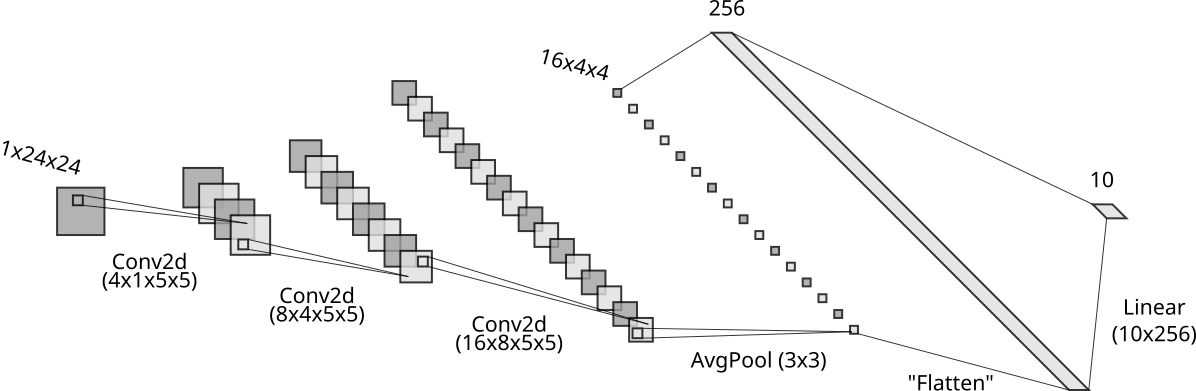

**Question:** It was mentioned that after all convolutions, the activation map has size 16 x 4 x 4. What is the size after each convolution step?

**Answer: 4 x 20 x 20, 8 x 16 x 16, 16 x 12 x 12.**

In [ ]:
class MNISTClassifierSimple(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 5)#TODO
        self.conv2 = torch.nn.Conv2d(4, 8, 5)#TODO
        self.conv3 = torch.nn.Conv2d(8, 16, 5)#TODO

        self.fc = torch.nn.Linear(256, 10)


    def forward(self, x):

        activation = F.relu(x)

        x = self.conv1(x)
        x = F.relu(x)
       
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        #pool
        x = F.avg_pool2d(x, 3)
        #rearrange x
        x = torch.flatten(x, 1)
        x =  self.fc(x)
        
        return x


Next, we take a look at the model structure for an object of this class:

**Question:** What is the number of parameters expected for this model? 100, 800, 3200, pooling, 2560, Number of chanels is counted as a parameter aswell which can be seen by the snippet below, addtionaly have the parameters, 4, 8 and 16.

In [ ]:
model = MNISTClassifierSimple()
model

**Answer**:

After answering the question above, write a snippet that can count the number of parameters of a model, knowing that `model.parameters()` gives you the list of all parameter tensors in `model`.

In [ ]:
total_params = sum(p.numel() for p  in model.parameters())
print(total_params)

for p in model.parameters():
    print(p.numel())

## Task 5: BatchNorm and Dropout

Based on the class above, define a new class `MNISTClassifier`, but adding `BatchNorm2d` layers after every convolution. In addition, add a `Dropout` layer right before the final fully-connected layer.

### Training and evaluation behavior

Note that these new layers have different behavior depending on whether the model is in training or evaluation mode.

- **Batch normalization**: During training, maintains running estimates of mean and variance of activations seen. During evaluation, uses (but doesn't update) those estimates to normalize.
- **Dropout**: Zeroes parts of the input uniformly at random during training. During evaluation keeps all inputs, but rescales it proportionally to the probability of keeping inputs during training.

The two main ways this can be controlled in PyTorch (before calling `model(inputs)`) are:

- Calling `model.train(is_training)`, where `is_training` is either `True` or `False`
- Using `torch.inference_mode` as a [decorator or context manager](#Decorators-and-context-managers), which forces any models within the context to be in evaluation mode

All the `torch.nn.Module`s within your model that contain differing behavior for training or evaluation will then behave accordingly.

In [ ]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 5)#TODO
        self.conv2 = torch.nn.Conv2d(4, 8, 5)#TODO
        self.conv3 = torch.nn.Conv2d(8, 16, 5)#TODO

        self.bn1 = torch.nn.BatchNorm2d(4)
        self.bn2 = torch.nn.BatchNorm2d(8)
        self.bn3 = torch.nn.BatchNorm2d(16)
        self.fc = torch.nn.Linear(256, 10)

        self.dropout = torch.nn.Dropout()


    def forward(self, x):

        activation = F.relu(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
       
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #pool
        x = F.avg_pool2d(x, 3)
        #rearrange x
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x =  self.fc(x)
        
        return x


model = MNISTClassifier()
total_params = sum(p.numel() for p  in model.parameters())
print(total_params)

for p in model.parameters():
    print(p.numel())


**Question:** How many new parameters did this change introduced to your model? Where are those parameters specifically coming from?

**Answer:** Same as before? 

total_params = sum(p.numel() for p  in model.parameters())
print(total_params)

for p in model.parameters():
    print(p.numel())

## Optimizers

Notice how `model.parameters()` gives us access to all the parameters of the model, regardless of how complex its parameter structure is. This convenience method is needed for optimization, as the optimizer needs to collect all the parameters that should be updated.

An optimizer object is our main way of updating parameters in PyTorch. One of the biggest advantages of using libraries such as PyTorch is that they facilitate the calculation of gradients by keeping track of what we do with tensors that have `requires_grad` set to `True`. With this information, a *computation graph* is implicitly built, and whenever we call the method `.backward()` on a scalar tensor (note that this is normally only possible on scalars!), PyTorch will backpropagate through this computation graph. Since the optimizer object keeps a list of all parameters that should be updated, it also manages their gradients. Thus, one can use `optimizer.zero_grad()` to zero the current gradients of those parameters and `optimizer.step()` to update parameters after a call to `.backward()` on a tensor involved in the same computation graph as the parameters the optimizer keeps track of.

### A note on logits
Our model was never told to output class probabilities, but it will still be trained as a classifier. In PyTorch, the usual way to handle this is through the `F.cross_entropy` loss, which is designed to take what are called **logits**: the raw values before applying the softmax activation function, exactly what our model already outputs. This allows to implement the usual cross entropy loss directly based on the logits, using a more numerically stable sequence of operations.

This is how an optimizer is used:

In [ ]:
# Adam optimizer with learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = MNISTClassifier()

# Get a batch of (random) data
inputs = torch.randn((3, 1, 24, 24))
labels = torch.randint(10, size=(3,))

# Set this before starting a training loop to ensure
# training-specific behavior (batch normalization and dropout)
# is turned on
model.train()

# First, we need to zero all gradients related to the parameters
# the optimizer is interested in
optimizer.zero_grad()

# Compute outputs and loss
outputs = model(inputs)
loss = F.cross_entropy(outputs, labels)
print('Loss before:', loss.item())

# Computes gradients of the loss w.r.t. all tensors involved
# in the computation that have "requires_grad=True"
loss.backward()

# Updates parameters using the gradients by applying the
# optimizer's update rule, learning rate, etc.
optimizer.step()

outputs = model(inputs)
loss = F.cross_entropy(outputs, labels)
print('Loss after:', loss.item())

## Task 6: An image classifier for MNIST

Using the class defined above, train your classifier on MNIST using the Adam optimizer. Initialize a new model instance and optimizer taking that model's parameters before starting training.

Additionally, instantiate a new Dataset with an extra transformation: it should apply `T.CenterCrop((24, 24))` to remove the unnecessary padding around the images.

In [ ]:
transform = T.Compose([
    T.PILToTensor(),
    T.ToDtype(torch.float32, scale = True),
    T.CenterCrop((24, 24))
])

# TODO
dataset = MNIST(
    '~/.data',
    train=True, 
    download=True,
transform=transform) 

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
    )

In [ ]:
model = MNISTClassifier()
#model = MNISTClassifierSimple()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

for epoch in range(num_epochs):
    avg_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
    print(f'[{epoch:04d}] avg_loss={avg_loss:4f}')

## Task 7: Calculate the accuracy of your model

Given the trained model above, calculate the accuracy of your model on the training and test data. Remember [this note](#Training-and-evaluation-behavior) when calculating it. As a suggestion, consider implementing a function that takes a model and loader and returns the accuracy.

**Hint:** `torch.argmax(x, dim=-1)` gives you the index of the largest value per row of `x` (if it is a matrix).

In [ ]:
transform = T.Compose([
    T.PILToTensor(),
    T.ToDtype(torch.float32, scale = True),
    T.CenterCrop((24, 24))
])

# Train
dataset_train = MNIST(
    '~/.data',
    train=True, 
    download=True,
transform=transform) 

loader_train = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True
    )

# Test
dataset_test = MNIST(
    '~/.data',
    train=False, 
    download=True,
transform=transform) 

loader_test = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=True
    )

correct = 0
counter = 0
for i, (inputs, labels) in enumerate(loader_train):
    counter += len(labels)
    outputs = model(inputs)
    _, index = torch.max(outputs,1)
    correct += (index == labels).sum().item()

print(correct/counter, "Accuracy for training")

correct = 0
counter = 0
for i, (inputs, labels) in enumerate(loader_test):
    counter += len(labels)
    outputs = model(inputs)
    _, index = torch.max(outputs,1)
    correct += (index == labels).sum().item()

print(correct/counter, "Accuracy for test")


## A note on reproducibility

When training deep learning models, it is important to ensure you can reproduce the results later, given the same inputs to your code. Here is a "laundry list" of things to think of when training your models. Let `seed` be an integer determining the seed for a pseudo-random number generator (PRNG).

- `torch.manual_seed(seed)` sets CPU and CUDA PRNGs
- `np.random.seed(seed)` (if your code uses the NumPy PRNG)
- `random.seed(seed)` (if your code uses the `random` module from the Python standard library)
- `torch.use_deterministic_algorithms(True)`

**Note:** If you use a `DataLoader` with `num_workers` $\neq 0$ (not the case here), make sure to set the worker initialization to control for seeds as well. See https://pytorch.org/docs/stable/notes/randomness.html for more details.

## Task 8: Comparing model performance

Experimentation with different models is the norm in machine learning. Compare the benefits of adding batch normalization and dropout by comparing the performance of `MNISTClassifierSimple` and `MNISTClassifier`. Save the average loss per epoch in an array and plot the average loss per epoch of both models. Which one performed better? How was the convergence behavior?

In [ ]:
# TODO: Replace with real values
losses1 = [0.260013, 0.117559, 0.099622, 0.091456, 0.085149]
losses2 = [0.278194, 0.101380, 0.070538, 0.056419, 0.047299] #simple


# Plotting two lines, e.g., lists of loss values
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
for s in 'top', 'right':
    ax.spines[s].set_visible(False)
ax.plot(losses1, 'r-', label='Model 1')
ax.plot(losses2, 'b-', label='Simple')
ax.legend()

## Task 9: Rotating MNIST

With a trained model, evaluate the probability assigned by it on a rotating digit, as shown below. Your task is to apply the `F.softmax` function to the model outputs and set the predicted class probability values accordingly.

In [ ]:
from torchvision.transforms.functional import rotate

# An image which is a 6
index = 100
x, label = dataset_test[index]

angles = list(range(0, 360, 45))
fig, axes = plt.subplots(nrows=1, ncols=len(angles), figsize=(len(angles) * 3, 3))
for i, angle in enumerate(angles):
    rot_x = rotate(x, angle)
    probs = F.softmax(model(torch.unsqueeze(rot_x, 1)), dim = 1)
    prob6 = probs[0, 6]
    prob9 = probs[0, 9]

    ax = axes[i]
    ax.set_axis_off()
    ax.set_title(f'{angle} deg.\np(6)={prob6:.2f}\np(9)={prob9:.2f}')
    ax.imshow(rot_x.permute(1, 2, 0), cmap='Grays')

# Appendix: Decorators and context managers

In PyTorch, there are some useful decorators and context managers for controlling its behavior. The most common ones are `torch.no_grad` and `torch.inference_mode`. But what are those?

## Decorators

A function decorator is a function that takes a function as argument and returns a function. In other words, it represents a "transformation" of a function. (Technically, classes that implement `__init__` and `__call__` can also act as decorators, but we ignore that for now.)

In [ ]:
def do_twice(func):
    def wrapper():
        func()
        func()
    return wrapper

def hello():
    print('hello, world')

print("Calling hello() as it is.")
hello()

print("\nCalling the transformed hello()")
transformed_hello = do_twice(hello)
transformed_hello()

Since writing this can get relatively tedious, Python supports a special syntax to simplify it:

In [ ]:
@do_twice
def hello():
    print('hello, world')

hello()


In PyTorch, `torch.no_grad`, transforms a function to no longer keep track of the computations done within, as a sign that you will not need to calculate gradients from those later. When evaluating models, this is usually what we want, as we don't need to keep track of the gradients. Beware that, due to its definition, `torch.no_grad` is both a context manager (more below) and can be used as a decorator.

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
    # Do evaluation here, no gradients will be kept track of
    model.train(False)
    pass

In addition, PyTorch also offers `torch.inference_mode`, which disables gradients as `torch.no_grad` (works also for forward-mode automatic differentiation, but this is not covered here and still in beta with unstable API). Models used in this mode will also have their behavior set to evaluation (also known as inference) mode, where layers like `BatchNorm2d` and `Dropout` behave differently.

In [ ]:
@torch.inference_mode()
def eval_model(model, loader):
    # Do evaluation here.
    # Notice that we don't need to call model.train(False). This is handled by the decorator!
    pass

## Context managers

Context managers are objects which implement three special methods: `__init__`, `__enter__` and `__exit__`. They are most commonly used as resource managers, but can more generally be used to define blocks of code where something is supposed to happen before (optionally) or after (optionally, but mostly desirable) it is executed.

In [ ]:
class HelloGoodbye:
    def __enter__(self):
        print('Hello')

    def __exit__(self, exc_type, exc_value, exc_traceback):
        print('Goodbye')

with HelloGoodbye():
    print('This message follows a hello and preceeds a goodbye.')

Notice that `__exit__` is given a few arguments as well. This implies and means that context managers can react to exceptions that happen within the context managed by it, allowing proper management of resources also when an exception occurs.

With `torch.no_grad` and `torch.inference_mode`, this is similar:

In [ ]:
with torch.no_grad():
    # No gradients are kept track of here
    pass

with torch.inference_mode():
    # In addition, models here are set to their evaluation (or inference) mode
    pass

## Deciding between decorators and context managers

Choosing which one to use depends on the intention of the code you are writing. Here we give simple principles to follow, which should be ignored when it gets in your way of writing clearer code.

The easiest example is if you are writing evaluation functions: annotate it with `@torch.inference_mode()` and you won't have to remember to set the model to evaluation mode and will not keep track of gradients unnecessarily. By extension, any function which is by purpose meant to run with a certain behavior, should probably be annotated accordingly.

Cases where context managers make most sense is when you have functions which are sometimes supposed to run with certain behavior and sometimes not. You can then write a single function and then decide later to call it within the `torch.no_grad()` context manager. In general, if you have a resource that should only be available for a limited amount of time and in specific contexts (hint is this), then a context manager is probably the natural solution in Python.